<a href="https://colab.research.google.com/github/Atadele1/INST414-Medium-Codes/blob/main/INST414_Module3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset loaded with 200 influencers
Available columns in the dataset:
['rank', 'channel_info', 'influence_score', 'posts', 'followers', 'avg_likes', '60_day_eng_rate', 'new_post_avg_like', 'total_likes', 'country']

Sample data (first 5 rows):
   rank channel_info  influence_score  posts followers avg_likes  \
0     1    cristiano               92   3.3k    475.8m      8.7m   
1     2  kyliejenner               91   6.9k    366.2m      8.3m   
2     3     leomessi               90  0.89k    357.3m      6.8m   
3     4  selenagomez               93   1.8k    342.7m      6.2m   
4     5      therock               91   6.8k    334.1m      1.9m   

  60_day_eng_rate new_post_avg_like total_likes        country  
0           1.39%              6.5m       29.0b          Spain  
1           1.62%              5.9m       57.4b  United States  
2           1.24%              4.4m        6.0b            NaN  
3           0.97%              3.3m       11.5b  United States  
4           0.20%     

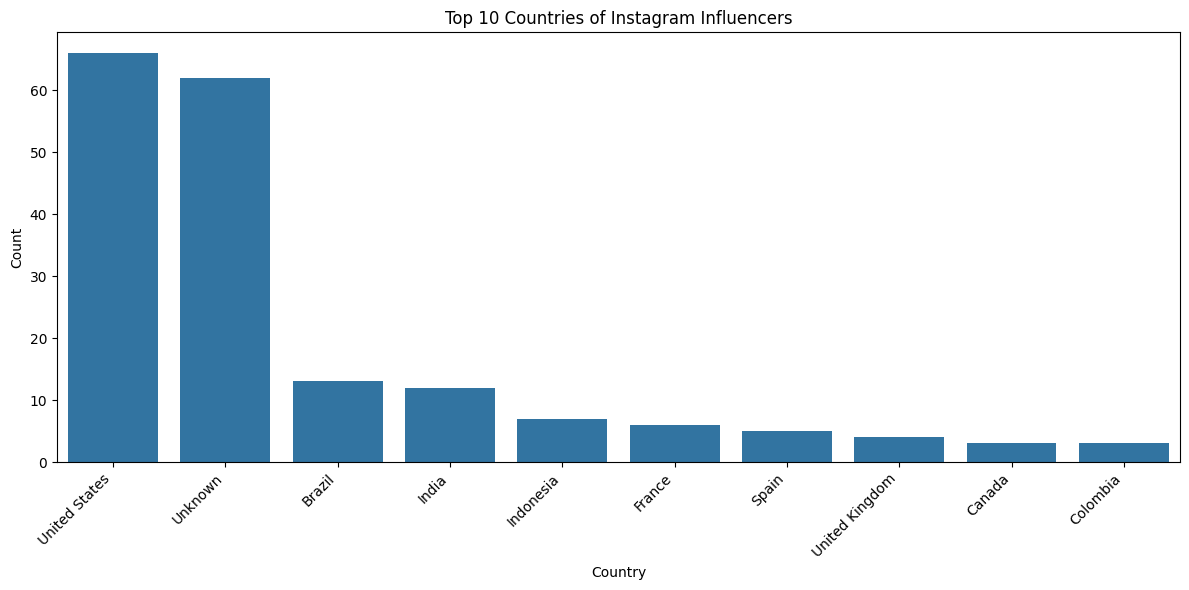

In [30]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset with the correct filename
df = pd.read_csv("top_insta_influencers_data.csv")

print(f"Dataset loaded with {len(df)} influencers")

# Print the column names to see what's available
print("Available columns in the dataset:")
print(df.columns.tolist())

# Print a sample of the data to understand its structure
print("\nSample data (first 5 rows):")
print(df.head())

def clean_instagram_data(df):
    """Clean and prepare the Instagram data for analysis"""
    # Make a copy to avoid modifying the original
    cleaned_df = df.copy()

    # Use channel_info as the name column
    name_col = 'channel_info'

    # Try to convert followers to numeric values
    # First check if there are any string values with K or M
    sample_followers = cleaned_df['followers'].dropna().astype(str).tolist()[:10]
    print(f"Sample followers values: {sample_followers}")

    # Convert followers to numeric if needed
    if any('K' in str(x) or 'M' in str(x) or 'B' in str(x) for x in sample_followers):
        cleaned_df['followers'] = cleaned_df['followers'].astype(str).str.replace('B', '000000000').str.replace('M', '000000').str.replace('K', '000')

    # Convert to numeric
    cleaned_df['followers'] = pd.to_numeric(cleaned_df['followers'], errors='coerce')

    # Use country as a category substitute
    category_col = 'country'
    cleaned_df[category_col] = cleaned_df[category_col].fillna('Unknown')

    # Create a combined text field for content-based similarity
    # Using channel_info and country since we don't have biography
    cleaned_df['text_content'] = cleaned_df.apply(
        lambda x: f"{x[name_col]} {x[category_col]} {x.get('influence_score', '')}",
        axis=1
    )

    return cleaned_df, name_col, category_col

def calculate_similarity(df, feature_column):
    """Calculate similarity matrix based on a specific feature"""
    # Convert text to a matrix of word counts
    vectorizer = CountVectorizer(stop_words='english')
    feature_matrix = vectorizer.fit_transform(df[feature_column])

    # Calculate similarity between each pair of accounts
    similarity = cosine_similarity(feature_matrix)

    return similarity

# Clean the data
cleaned_df, name_col, category_col = clean_instagram_data(df)

# Calculate content-based similarity
content_similarity = calculate_similarity(cleaned_df, 'text_content')

# Calculate category-based similarity
category_similarity = calculate_similarity(cleaned_df, category_col)

# Combine with weights (70% content, 30% category)
combined_similarity = (content_similarity * 0.7) + (category_similarity * 0.3)

# Analyze top influencers by engagement rate instead of followers
print("\nTop 10 Influencers by Engagement Rate:")
top_by_engagement = cleaned_df.sort_values('60_day_eng_rate', ascending=False).head(10)
print(top_by_engagement[[name_col, '60_day_eng_rate', 'followers']])

# Analyze top influencers by total likes
print("\nTop 10 Influencers by Total Likes:")
top_by_likes = cleaned_df.sort_values('total_likes', ascending=False).head(10)
print(top_by_likes[[name_col, 'total_likes', 'followers']])

# Analyze country distribution
country_counts = cleaned_df['country'].value_counts()
print("\nCountry Distribution:")
print(country_counts.head(10))

# Visualize country distribution
plt.figure(figsize=(12, 6))
top_countries = country_counts.head(10)
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title('Top 10 Countries of Instagram Influencers')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('country_distribution.png')

# Recommend similar influencers function
def recommend_similar_influencers(influencer_name, similarity_matrix, df, name_col, top_n=5):
    """Recommend similar influencers based on similarity matrix"""
    # Find the index of the influencer
    try:
        idx = df[df[name_col] == influencer_name].index[0]
    except IndexError:
        print(f"Influencer '{influencer_name}' not found in the dataset")
        return pd.DataFrame()

    # Get similarity scores for this influencer
    similarity_scores = list(enumerate(similarity_matrix[idx]))

    # Sort by similarity score (descending)
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get top N similar influencers (excluding the influencer itself)
    similar_indices = [i[0] for i in similarity_scores[1:top_n+1]]

    return df.iloc[similar_indices][[name_col, category_col, 'followers', 'influence_score']]

# Example: Find similar influencers to a popular one
popular_influencer = cleaned_df[name_col].iloc[0]  # Using the first one (cristiano)
print(f"\nInfluencers similar to {popular_influencer}:")
similar_influencers = recommend_similar_influencers(popular_influencer, combined_similarity, cleaned_df, name_col)
print(similar_influencers)

# Try another popular influencer
second_popular = cleaned_df[name_col].iloc[1]  # Using the second one (kyliejenner)
print(f"\nInfluencers similar to {second_popular}:")
similar_influencers2 = recommend_similar_influencers(second_popular, combined_similarity, cleaned_df, name_col)
print(similar_influencers2)

# Save the cleaned data to a new CSV file
cleaned_df.to_csv('cleaned_instagram_influencers.csv', index=False)

In [31]:
# Load the dataset
import pandas as pd
df = pd.read_csv("top_insta_influencers_data.csv")
print(f"Dataset loaded with {len(df)} influencers")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def clean_instagram_data(df):
    """Clean and prepare the Instagram data for analysis"""
    cleaned_df = df.copy()

    # Use channel_info as the name column
    name_col = 'channel_info'

    # Use country as a category substitute
    category_col = 'country'
    cleaned_df[category_col] = cleaned_df[category_col].fillna('Unknown')

    # Create a combined text field for content-based similarity
    cleaned_df['text_content'] = cleaned_df.apply(
        lambda x: f"{x[name_col]} {x[category_col]} {x.get('influence_score', '')}",
        axis=1
    )

    return cleaned_df, name_col, category_col

def calculate_similarity(df, feature_column):
    """Calculate similarity matrix based on a specific feature"""
    vectorizer = CountVectorizer(stop_words='english')
    feature_matrix = vectorizer.fit_transform(df[feature_column])
    similarity = cosine_similarity(feature_matrix)
    return similarity

# Clean the data
cleaned_df, name_col, category_col = clean_instagram_data(df)

# Calculate content-based similarity
content_similarity = calculate_similarity(cleaned_df, 'text_content')

# Calculate category-based similarity
category_similarity = calculate_similarity(cleaned_df, category_col)

# Combine with weights (70% content, 30% category)
combined_similarity = (content_similarity * 0.7) + (category_similarity * 0.3)


def recommend_similar_influencers(influencer_name, similarity_matrix, df, name_col, top_n=10):
    """Recommend similar influencers based on similarity matrix"""
    idx = df[df[name_col] == influencer_name].index[0]
    similarity_scores = list(enumerate(similarity_matrix[idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similar_indices = [i[0] for i in similarity_scores[1:top_n+1]]
    return df.iloc[similar_indices][[name_col, category_col, 'influence_score']]

# Find influencers similar to Cristiano Ronaldo
cristiano_similar = recommend_similar_influencers("cristiano", combined_similarity, cleaned_df, name_col)
print("Top 10 influencers similar to Cristiano Ronaldo:")
print(cristiano_similar)

# Find influencers similar to Kylie Jenner
kylie_similar = recommend_similar_influencers("kyliejenner", combined_similarity, cleaned_df, name_col)
print("Top 10 influencers similar to Kylie Jenner:")
print(kylie_similar)


# Find influencers similar to National Geographic
natgeo_similar = recommend_similar_influencers("natgeo", combined_similarity, cleaned_df, name_col)
print("Top 10 influencers similar to National Geographic:")
print(natgeo_similar)

Dataset loaded with 200 influencers
Top 10 influencers similar to Cristiano Ronaldo:
       channel_info        country  influence_score
28       realmadrid          Spain               90
76     karimbenzema          Spain               42
134   buzzfeedtasty          Spain               85
149  andresiniesta8          Spain               85
20        katyperry        Unknown               92
6      arianagrande  United States               92
7           beyonce  United States               92
1       kyliejenner  United States               91
2          leomessi        Unknown               90
3       selenagomez  United States               93
Top 10 influencers similar to Kylie Jenner:
       channel_info        country  influence_score
4           therock  United States               91
5     kimkardashian  United States               91
11           natgeo  United States               91
13      taylorswift  United States               91
3       selenagomez  United States     

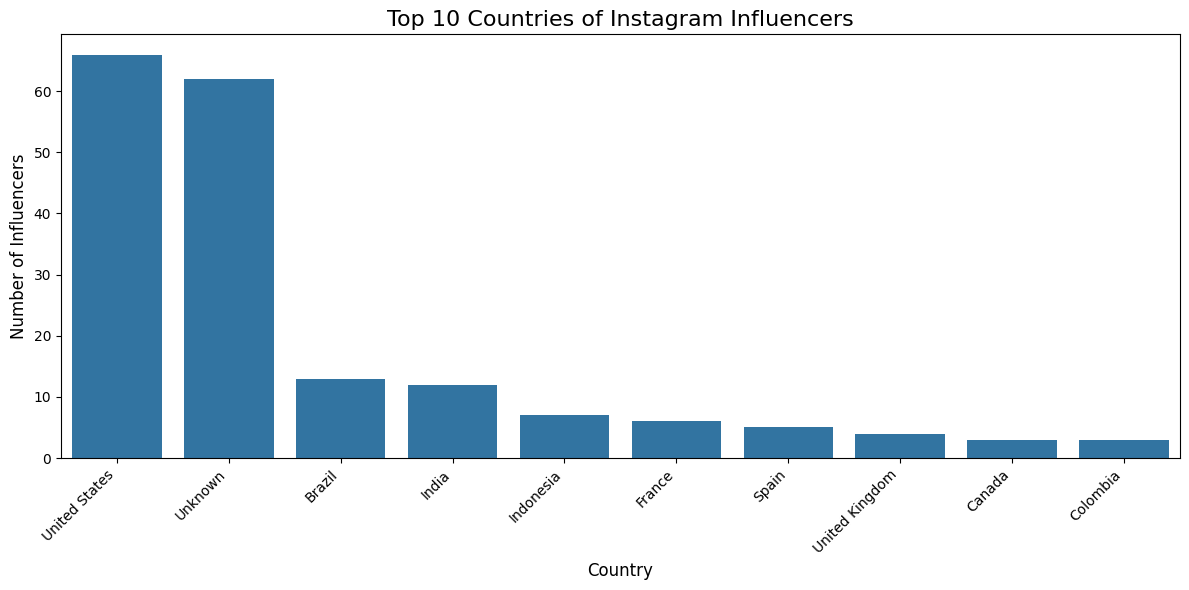

In [63]:
# Country Distribution Graph
# Country Distribution Graph
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
top_countries = cleaned_df['country'].value_counts().head(10)
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title('Top 10 Countries of Instagram Influencers', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Influencers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# Display the graph directly instead of saving
plt.savefig('country_distribution.png')
plt.show()


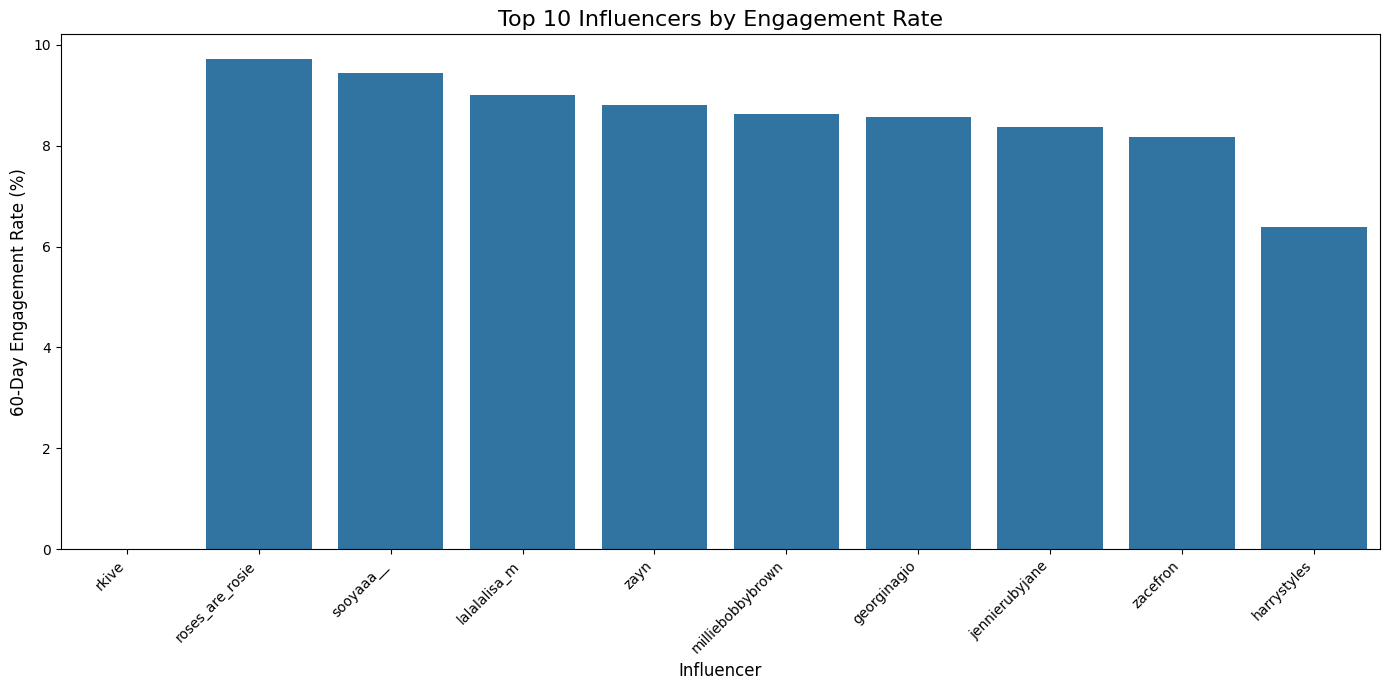

In [62]:
# Engagement Rate Comparison Graph
plt.figure(figsize=(14, 7))
top_engagement = cleaned_df.sort_values('60_day_eng_rate', ascending=False).head(10)
# Convert engagement rate to numeric by removing % sign
top_engagement['engagement_numeric'] = top_engagement['60_day_eng_rate'].str.replace('%', '').astype(float)
sns.barplot(x=top_engagement['channel_info'], y=top_engagement['engagement_numeric'])
plt.title('Top 10 Influencers by Engagement Rate', fontsize=16)
plt.xlabel('Influencer', fontsize=12)
plt.ylabel('60-Day Engagement Rate (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# Display the graph directly instead of saving
plt.savefig('engagement_rate_comparison.png')
plt.show()


<ipython-input-61-79f9d825fffb>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Influencer', data=heatmap_df, palette='viridis')


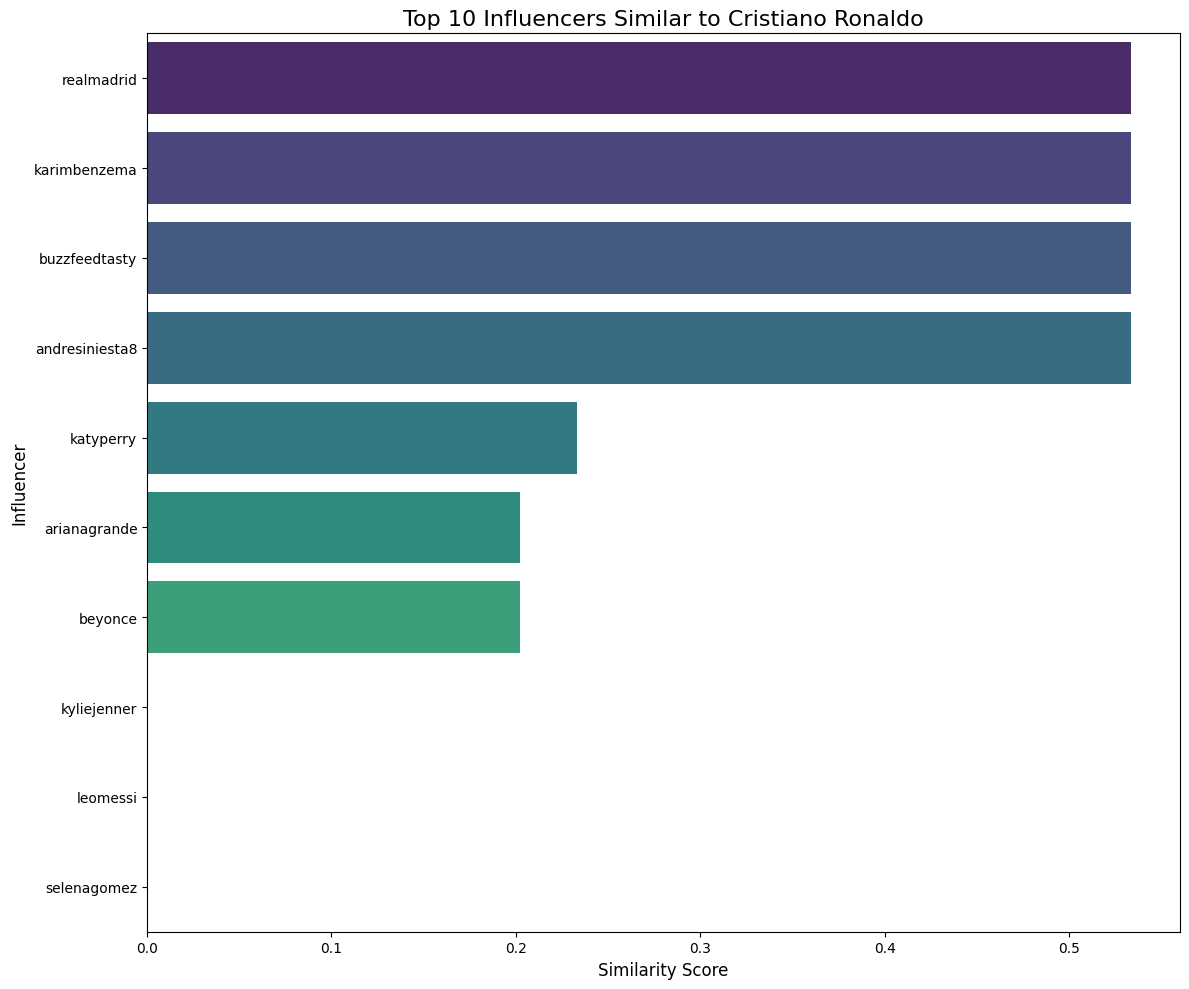

In [61]:
# Similarity Heatmap for Cristiano Ronaldo
plt.figure(figsize=(12, 10))
# Get index of Cristiano Ronaldo
cristiano_idx = cleaned_df[cleaned_df['channel_info'] == 'cristiano'].index[0]
# Get top 10 similar influencers
similarity_scores = list(enumerate(combined_similarity[cristiano_idx]))
similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
similar_indices = [i[0] for i in similarity_scores[1:11]]  # Skip first (self)
similar_scores = [i[1] for i in similarity_scores[1:11]]

# Create a small dataframe for the heatmap
similar_influencers = cleaned_df.iloc[similar_indices]['channel_info'].tolist()
heatmap_df = pd.DataFrame({'Influencer': similar_influencers, 'Similarity': similar_scores})

# Plot heatmap
sns.barplot(x='Similarity', y='Influencer', data=heatmap_df, palette='viridis')
plt.title('Top 10 Influencers Similar to Cristiano Ronaldo', fontsize=16)
plt.xlabel('Similarity Score', fontsize=12)
plt.ylabel('Influencer', fontsize=12)
plt.tight_layout()
# Display the graph directly instead of saving
plt.savefig('cristiano_similarity_heatmap.png')
plt.show()


<ipython-input-60-8f41580a8a26>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity', y='Influencer', data=heatmap_df, palette='viridis')


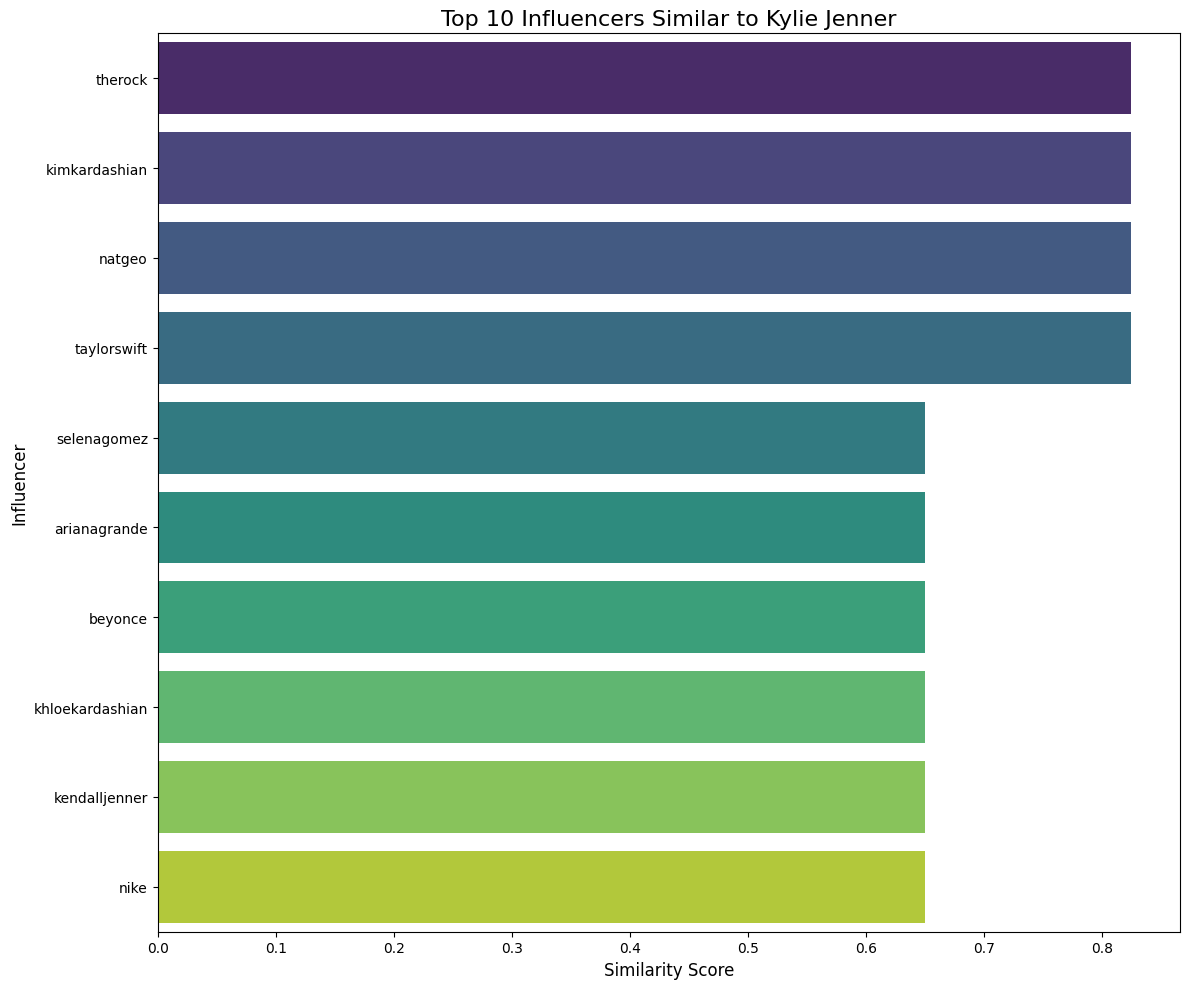

In [60]:
# Similarity Heatmap for Kylie Jenner
plt.figure(figsize=(12, 10))
# Get index of Kylie Jenner
kylie_idx = cleaned_df[cleaned_df['channel_info'] == 'kyliejenner'].index[0]
# Get top 10 similar influencers
similarity_scores = list(enumerate(combined_similarity[kylie_idx]))
similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
similar_indices = [i[0] for i in similarity_scores[1:11]]  # Skip first (self)
similar_scores = [i[1] for i in similarity_scores[1:11]]

# Create a small dataframe for the heatmap
similar_influencers = cleaned_df.iloc[similar_indices]['channel_info'].tolist()
heatmap_df = pd.DataFrame({'Influencer': similar_influencers, 'Similarity': similar_scores})

# Plot heatmap
sns.barplot(x='Similarity', y='Influencer', data=heatmap_df, palette='viridis')
plt.title('Top 10 Influencers Similar to Kylie Jenner', fontsize=16)
plt.xlabel('Similarity Score', fontsize=12)
plt.ylabel('Influencer', fontsize=12)
plt.tight_layout()
# Display the graph directly instead of saving
plt.savefig('kylie_similarity_heatmap.png')
plt.show()


In [39]:
from IPython.display import display

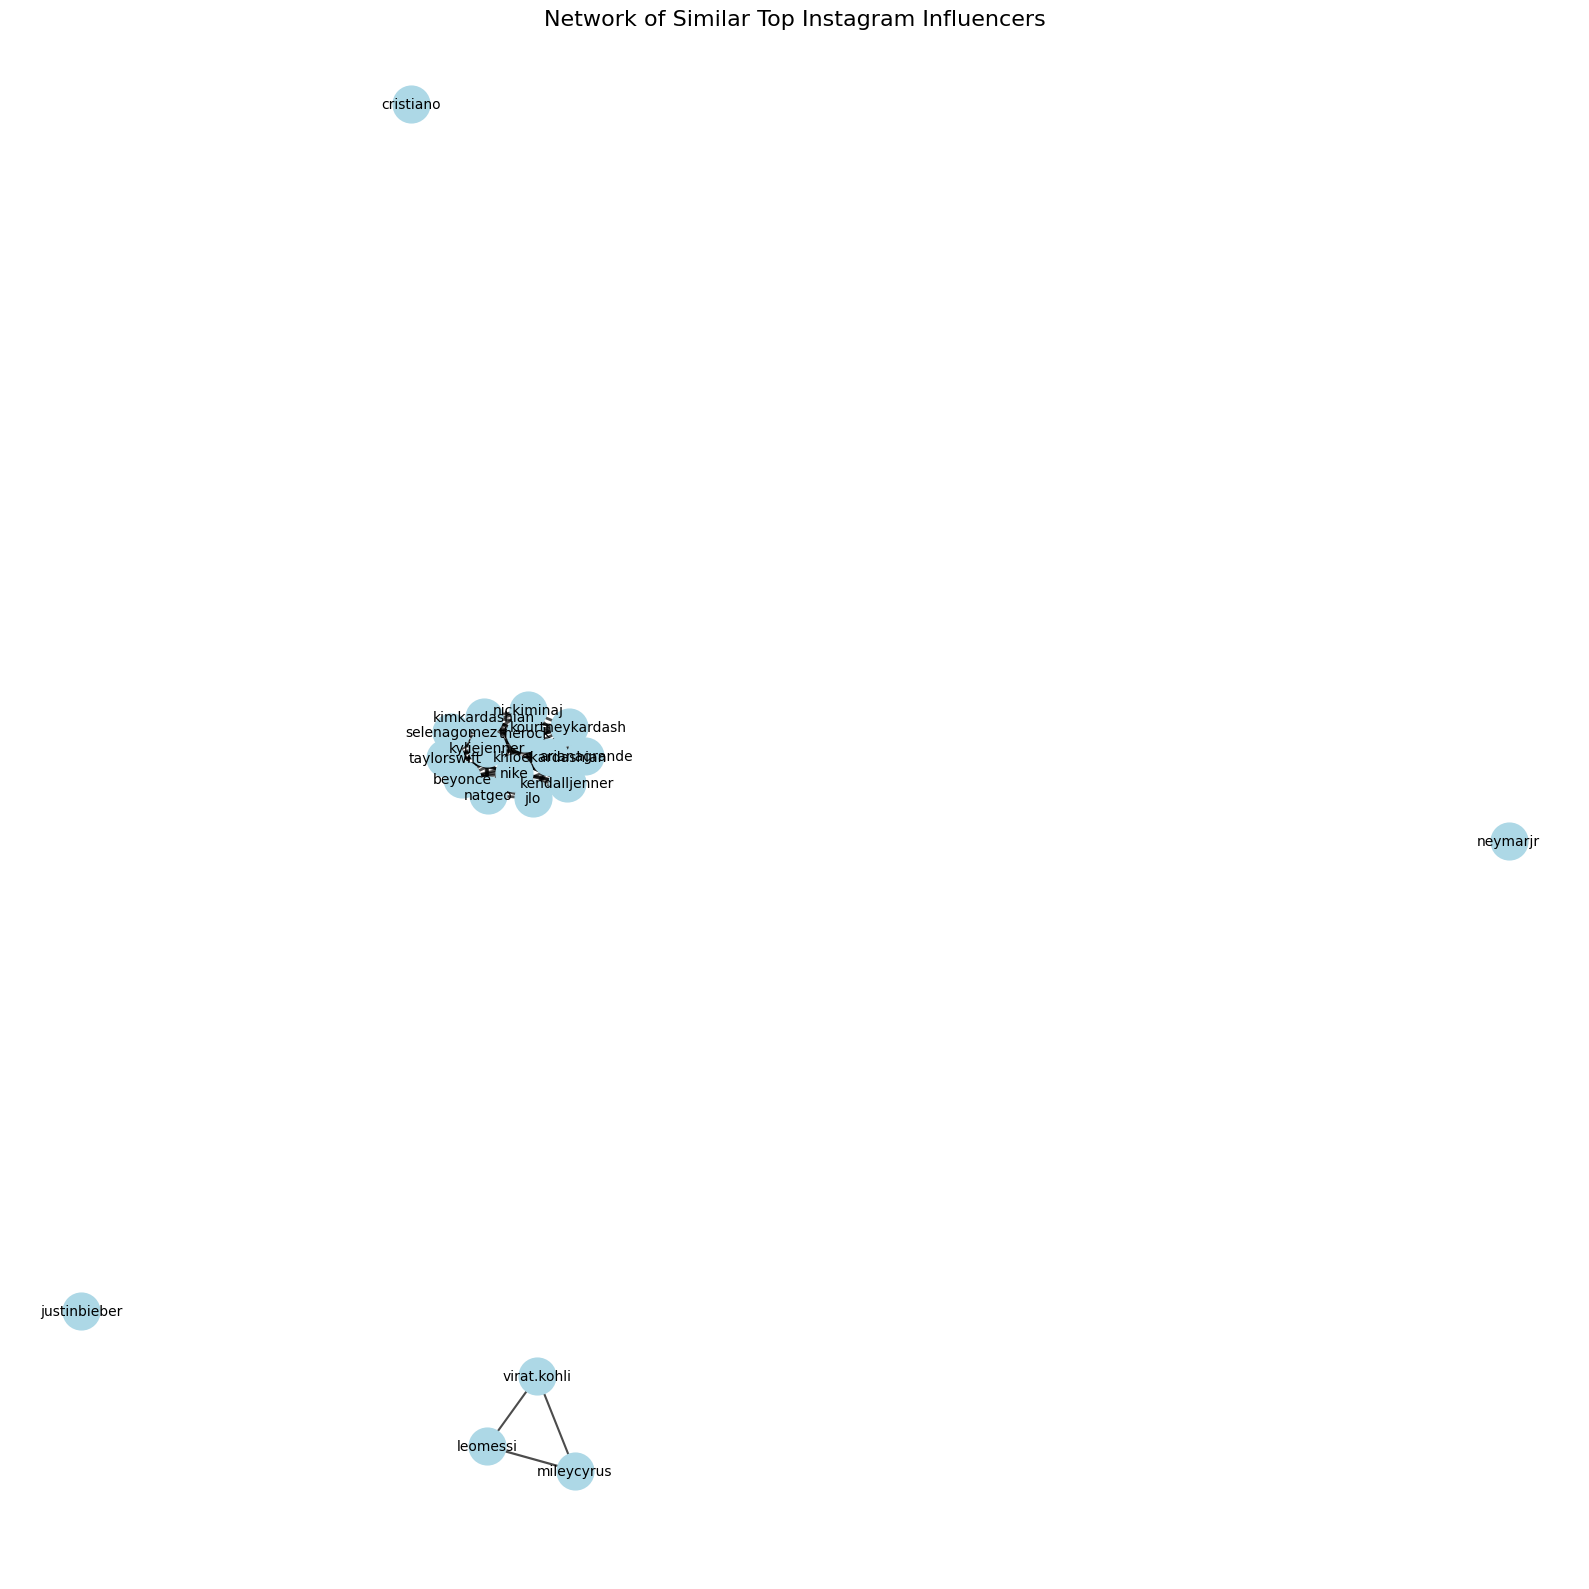

In [64]:
# Network Graph of Influencer Relationships
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sn

# Create a network graph for top 20 influencers
plt.figure(figsize=(16, 16))
top_influencers = cleaned_df.head(20)['channel_info'].tolist()

# Create a graph
G = nx.Graph()

# Add nodes
for influencer in top_influencers:
    G.add_node(influencer)

# Add edges based on similarity
threshold = 0.5  # Only connect if similarity is above threshold
for i, inf1 in enumerate(top_influencers):
    idx1 = cleaned_df[cleaned_df['channel_info'] == inf1].index[0]
    for j, inf2 in enumerate(top_influencers):
        if i < j:  # Avoid duplicate edges
            idx2 = cleaned_df[cleaned_df['channel_info'] == inf2].index[0]
            similarity = combined_similarity[idx1, idx2]
            if similarity > threshold:
                G.add_edge(inf1, inf2, weight=similarity)

# Set positions using force-directed layout
pos = nx.spring_layout(G, seed=42)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')

# Draw edges with width based on similarity
edges = G.edges(data=True)
weights = [d['weight']*3 for u, v, d in edges]
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.7)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')


plt.axis('off')
plt.title('Network of Similar Top Instagram Influencers', fontsize=16)
plt.tight_layout()
# Display the graph directly instead of saving
plt.savefig('influencer_network.png')
plt.show()


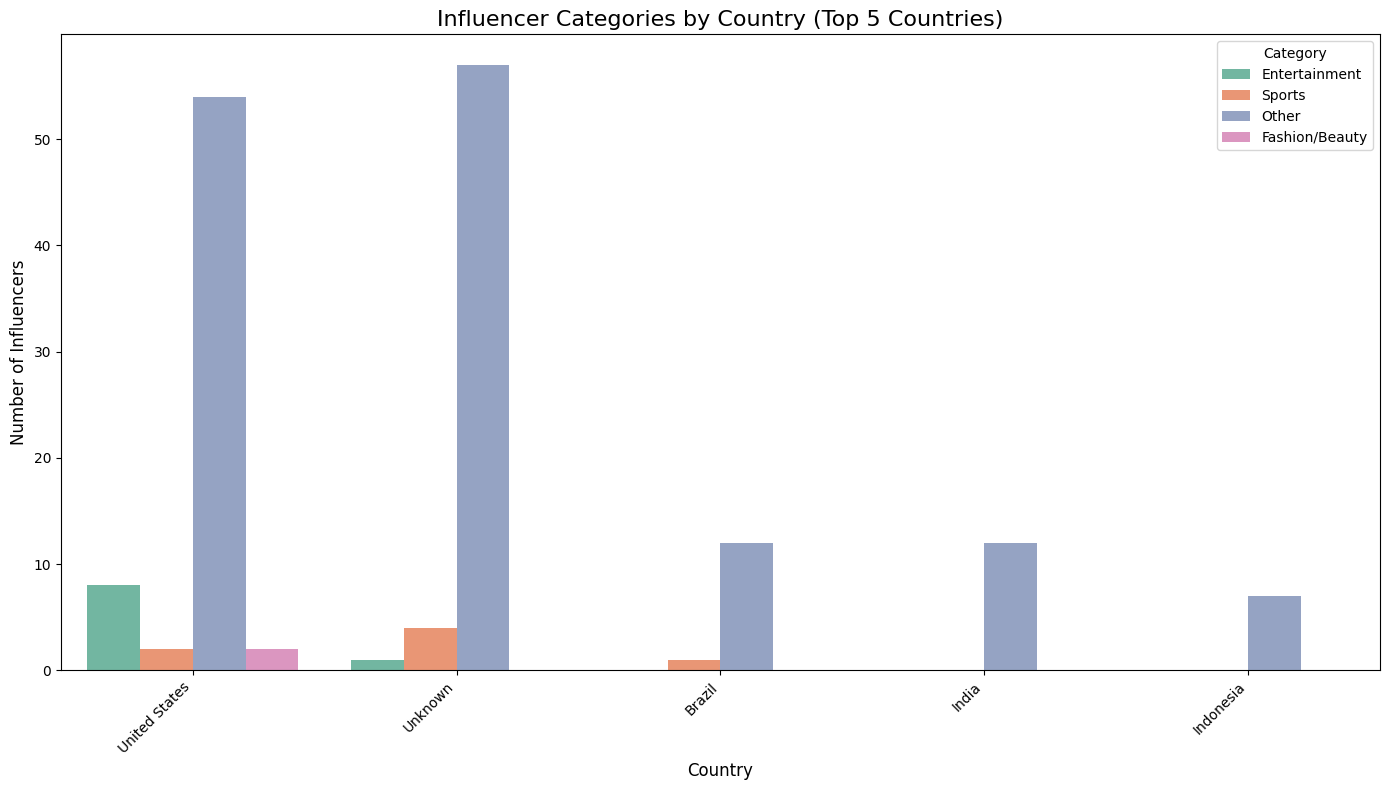

In [65]:
import matplotlib.pyplot as plt
import seaborn as sn
# Create a category field based on username patterns
def categorize_influencer(username):
    sports_keywords = ['football', 'soccer', 'sport', 'fc', 'real', 'champions', 'league',
                      'juventus', 'madrid', 'barcelona', 'messi', 'ronaldo', 'neymar']
    entertainment_keywords = ['music', 'singer', 'actor', 'actress', 'movie', 'film', 'hollywood',
                             'kardashian', 'jenner', 'swift', 'grande', 'bieber', 'gomez']
    fashion_keywords = ['fashion', 'model', 'style', 'beauty', 'makeup', 'cosmetic']

    username = username.lower()

    if any(keyword in username for keyword in sports_keywords):
        return 'Sports'
    elif any(keyword in username for keyword in entertainment_keywords):
        return 'Entertainment'
    elif any(keyword in username for keyword in fashion_keywords):
        return 'Fashion/Beauty'
    else:
        return 'Other'

# Apply categorization
cleaned_df['category'] = cleaned_df['channel_info'].apply(categorize_influencer)

# Plot category distribution by country
plt.figure(figsize=(14, 8))
top_countries = cleaned_df['country'].value_counts().head(5).index.tolist()
country_cat_df = cleaned_df[cleaned_df['country'].isin(top_countries)]

# Create the grouped bar chart
sns.countplot(x='country', hue='category', data=country_cat_df, palette='Set2')
plt.title('Influencer Categories by Country (Top 5 Countries)', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Influencers', fontsize=12)
plt.legend(title='Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the graph directly
plt.savefig('category_distribution_by_country.png')
plt.show()
